In [1]:
import pandas as pd
import pylab as pl
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from utils import normalizer

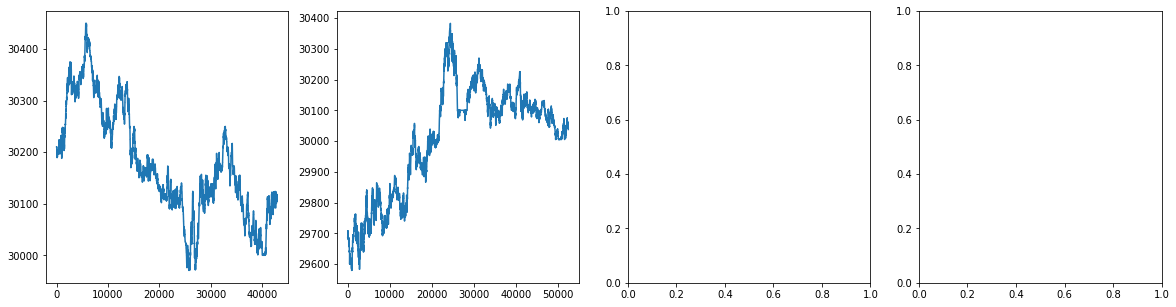

In [66]:

dates = ['19-Apr-2022','04-May-2022','10-May-2022','17-May-2022']
dates = ['09-Jun-2022', '10-Jun-2022']

agg_trade = []
for idx, date in enumerate(dates):
    agg_trade.append(pd.read_csv('./input_data/'+date+'/orderbook_agg_trade_dollarvol.csv'))

fig, ax = plt.subplots(1, 4, figsize = (20, 5))

ax[0].plot(agg_trade[0].price)
ax[1].plot(agg_trade[1].price)
# ax[2].plot(agg_trade[2].price)
# ax[3].plot(agg_trade[3].price)


## Data Normalization

In [67]:
norm_scaler = normalizer.Normalizer()
min_max_sclaer = normalizer.MinMax()

norm_scaler.fit_transform(agg_trade[0].price.to_list())
agg_trade_price_norm = [norm_scaler.transform(agg_trade[idx].price.to_list()) for idx in range(len(agg_trade))]

min_max_sclaer.fit_transform(agg_trade[0].price.to_list())
agg_trade_price_minmax = [min_max_sclaer.transform(agg_trade[idx].price.to_list()) for idx in range(len(agg_trade))]

IndexError: list index out of range

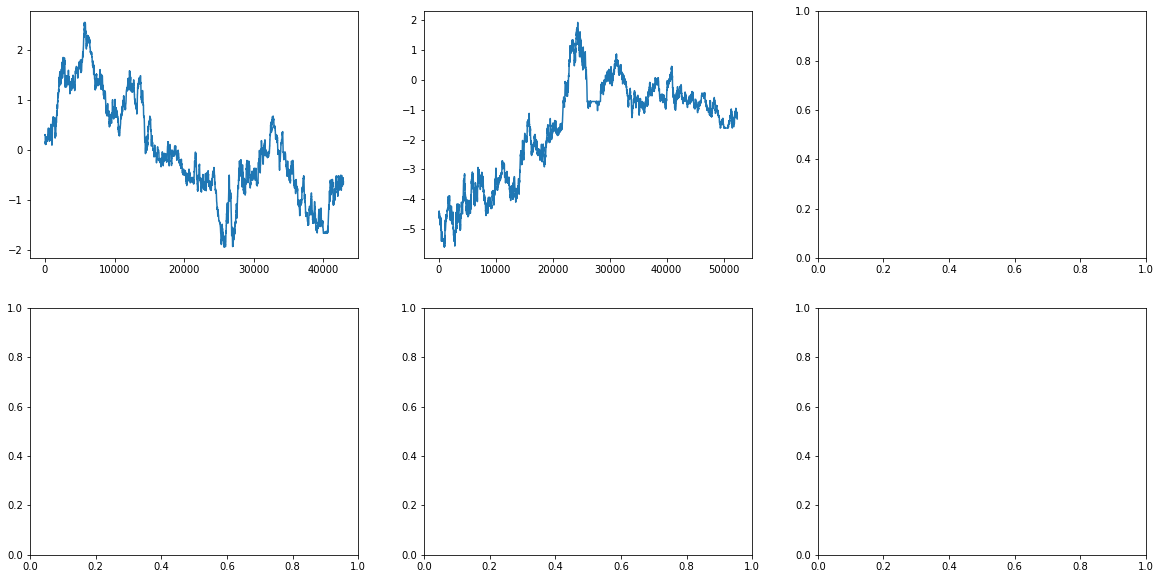

In [68]:
fig2, ax2 = plt.subplots(2, 3, figsize = (20, 10))

ax2[0][0].plot(agg_trade_price_norm[0])
ax2[0][1].plot(agg_trade_price_norm[1])
ax2[0][2].plot(agg_trade_price_norm[2])

ax2[1][0].plot(agg_trade_price_minmax[0])
ax2[1][1].plot(agg_trade_price_minmax[1])
ax2[1][2].plot(agg_trade_price_minmax[2])

In [69]:
# Taken from https://github.com/simaki/fracdiff

def fast_fracdiff(x, d):
    T = len(x)
    np2 = int(2 ** np.ceil(np.log2(2 * T - 1)))
    k = np.arange(1, T)
    b = (1,) + tuple(np.cumprod((k - d - 1) / k))
    z = (0,) * (np2 - T)
    z1 = b + z
    z2 = tuple(x) + z
    dx = pl.ifft(pl.fft(z1) * pl.fft(z2))
    return np.real(dx[0:T])

def get_weight_ffd(d, thres, lim):
    w, k = [1.], 1
    ctr = 0
    while True:
        w_ = -w[-1] / k * (d - k + 1)
        if abs(w_) < thres:
            break
        w.append(w_)
        k += 1
        ctr += 1
        if ctr == lim - 1:
            break
    w = np.array(w[::-1]).reshape(-1, 1)
    return w
  
def frac_diff_ffd(x, d, thres=1e-5):
    w = get_weight_ffd(d, thres, len(x))
    width = len(w) - 1
    output = []
    output.extend([0] * width)
    for i in range(width, len(x)):
        output.append(np.dot(w.T, x[i - width:i + 1])[0])
    return np.array(output)

In [74]:
test = frac_diff_ffd(agg_trade_price_norm[1], 0.1)

test1 = normalizer.consecutive_diff(agg_trade[1].price)
adfuller(test)

(-2.969528843197082,
 0.03783967912157645,
 28,
 52386,
 {'1%': -3.4304748352700734,
  '5%': -2.861595174680978,
  '10%': -2.5667993676482497},
 -297370.74665795604)

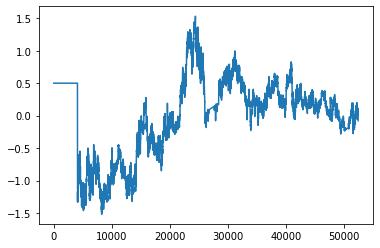

In [75]:
plt.plot(test[:]-np.mean(test[:]))
#plt.plot(test1[2000:2200])

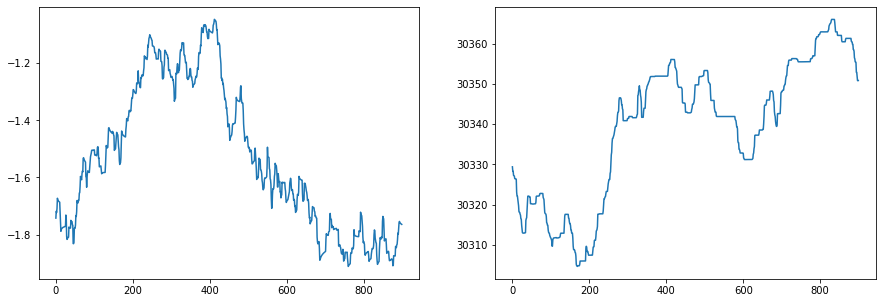

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(test[4100:5000])
ax[1].plot(agg_trade[0].price.to_list()[4100:5000])

IndexError: list index out of range

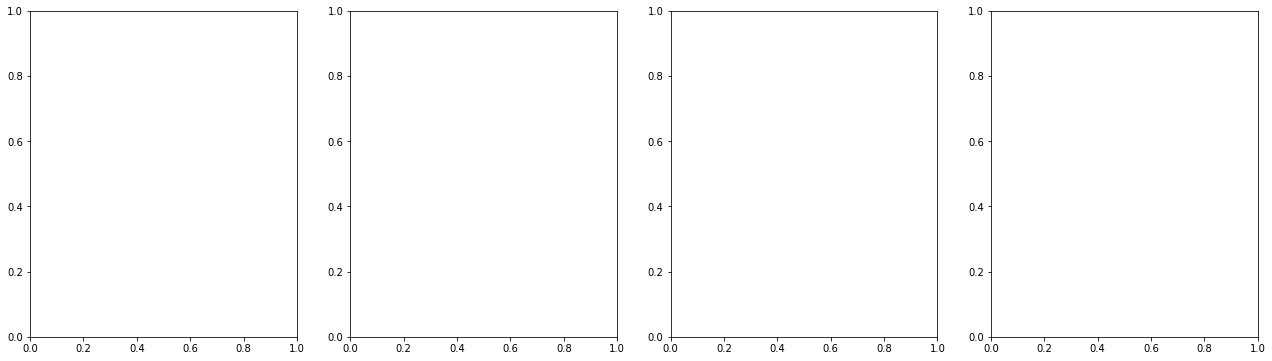

In [57]:
fig, ax = plt.subplots(1, 4, figsize = (22, 6))

prices1 = (np.array(agg_trade[0].price.to_list())-np.mean(agg_trade[0].price.to_list()))/np.std(agg_trade[0].price.to_list())
prices2 = (np.array(agg_trade[1].price.to_list())-np.mean(agg_trade[1].price.to_list()))/np.std(agg_trade[1].price.to_list())
prices3 = (np.array(agg_trade[2].price.to_list())-np.mean(agg_trade[2].price.to_list()))/np.std(agg_trade[2].price.to_list())
prices4 = (np.array(agg_trade[3].price.to_list())-np.mean(agg_trade[3].price.to_list()))/np.std(agg_trade[3].price.to_list())

ax[0].plot(prices1[:20])
ax[1].plot(prices2[:20])
ax[2].plot(prices3[:20])
ax[3].plot(prices4[:20])

In [18]:
prices_deavg_0 = normalizer.moving_average_standardization(agg_trade[0].price, agg_trade[0].quantity, 100)
prices_deavg_1 = normalizer.moving_average_standardization(agg_trade[1].price, agg_trade[1].quantity, 100)
prices_deavg_2 = normalizer.moving_average_standardization(agg_trade[2].price, agg_trade[2].quantity, 100)

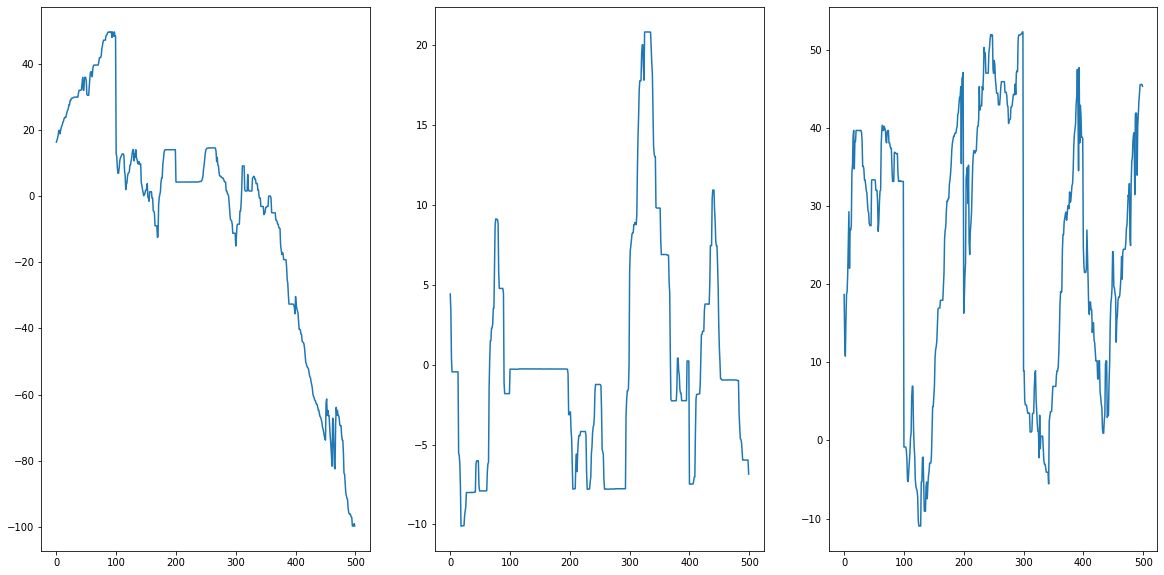

In [19]:
fig3, ax3 = plt.subplots(1, 3, figsize = (20, 10))

ax3[0].plot(prices_deavg_0[:500])
ax3[1].plot(prices_deavg_1[:500])
ax3[2].plot(prices_deavg_2[:500])

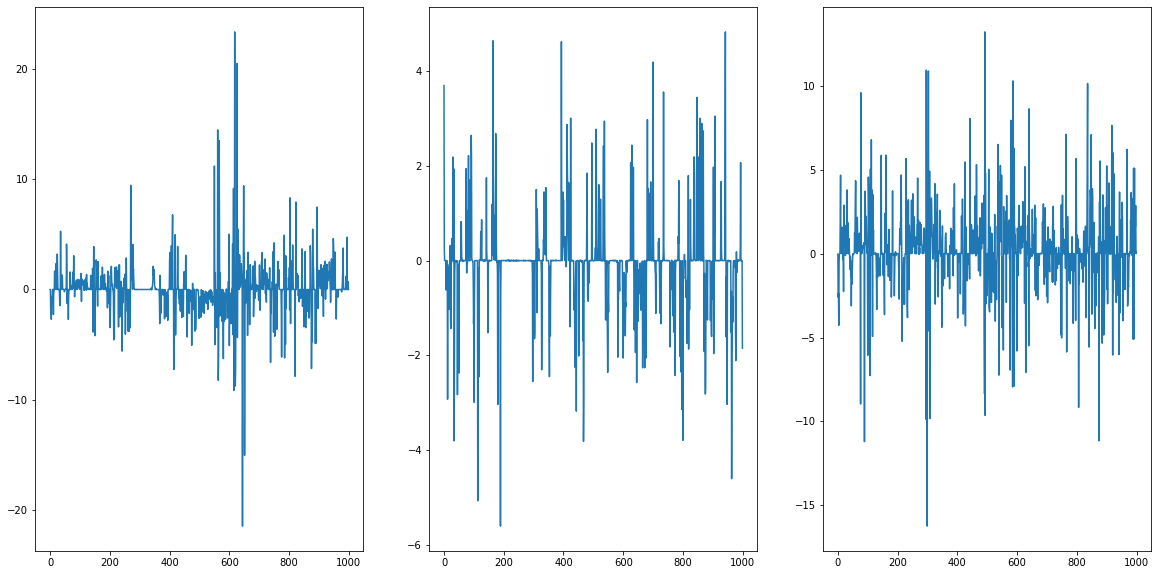

In [20]:
fig4, ax4 = plt.subplots(1, 3, figsize = (20, 10))

ax4[0].plot(normalizer.consecutive_diff(agg_trade[0].price)[:1000])
ax4[1].plot(normalizer.consecutive_diff(agg_trade[1].price)[:1000])
ax4[2].plot(normalizer.consecutive_diff(agg_trade[2].price)[:1000])

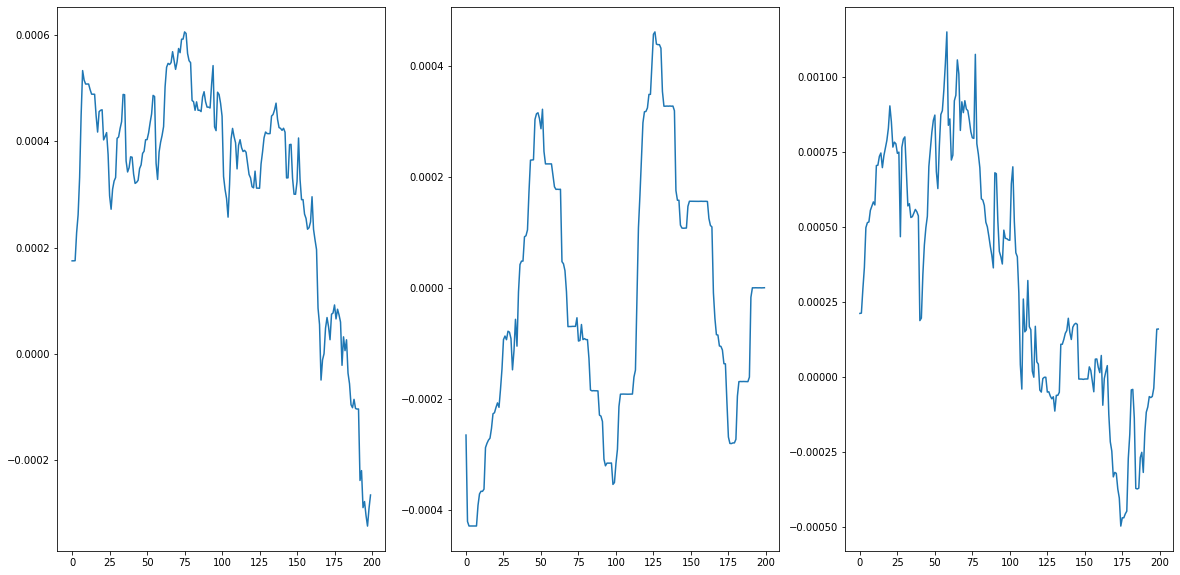

In [24]:
fig5, ax5 = plt.subplots(1, 3, figsize = (20, 10))

ax5[0].plot(normalizer.consecutive_window_diff(normalizer.log(agg_trade[0].price.to_list()), 50)[:200])
ax5[1].plot(normalizer.consecutive_window_diff(normalizer.log(agg_trade[1].price.to_list()), 50)[:200])
ax5[2].plot(normalizer.consecutive_window_diff(normalizer.log(agg_trade[2].price.to_list()), 50)[:200])

In [ ]:
test = normalizer.ewma_linear_filter(np.array(agg_trade[0].price.to_list()), 5)
plt.plot(test[:100])
plt.plot(agg_trade[0].price.to_list()[:100])

In [25]:
norm_scaler = normalizer.Normalizer()
min_max_scaler = normalizer.MinMax()

prices1 = norm_scaler.fit_transform(normalizer.consecutive_window_diff(normalizer.log(agg_trade[0].price.to_list()), 50))
prices2 = norm_scaler.transform(normalizer.consecutive_window_diff(normalizer.log(agg_trade[1].price.to_list()), 50))
prices3 = norm_scaler.transform(normalizer.consecutive_window_diff(normalizer.log(agg_trade[2].price.to_list()), 50))

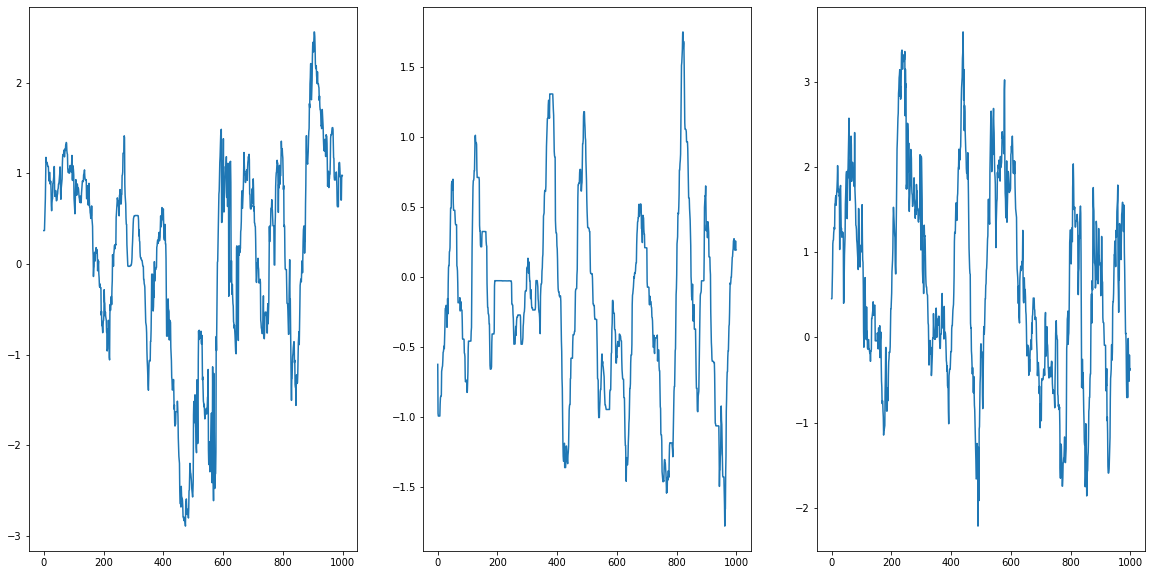

In [27]:
fig6, ax6 = plt.subplots(1, 3, figsize = (20, 10))

ax6[0].plot(prices1[:1000])
ax6[1].plot(prices2[:1000])
ax6[2].plot(prices3[:1000])